<a href="https://colab.research.google.com/github/RitvikPrabhu/AutoCBC/blob/master/Milestone2_DiseaseDetect/YOLOv8/Disease_detect_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**HemeAI: Disease Detection**

###Author: Ritvik Prabhu and Bhargav Iyer

Below we will clone our repository. The repository will contain the model files, annotated dataset and setup.py which are all necessary to train the model used for the first milestone of the project.

In [2]:
from IPython.display import clear_output

In [3]:
!git clone https://github.com/RitvikPrabhu/AutoCBC.git
%cd AutoCBC
!pip install -r requirements.txt
%cd Milestone2_DiseaseDetect/yolov8
clear_output()

The code below will allows us to reset our directory without having to shutdown the entire runtime

In [4]:
# !rm -rf AutoCBC/


Import the necessary files and ensure the hardware is compatible

In [5]:
import ultralytics
from ultralyticsplus import YOLO, render_result

ultralytics.checks()

Ultralytics YOLOv8.0.23 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.5/78.2 GB disk)


In [6]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="k7t7R1s1qjS9eojgbD50")
#project = rf.workspace("blood-cell-uoqgu").project("hemeai")
#dataset = project.version(1).download("yolov8")

#rf = Roboflow(api_key="k7t7R1s1qjS9eojgbD50")
project = rf.workspace().project("disease-detection-z1mqc")
dataset = project.version(3).download("yolov8")
clear_output()

In [7]:
#import os
import shutil

shutil.move("/content/AutoCBC/Disease-Detection-3", "/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/Disease-Detection-3")
shutil.move("/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/Disease-Detection-3/data.yaml", "/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/data.yaml")

#old_name = r"/content/AutoCBC/Disease-Detection-1/data.yaml"
#new_name = r"/content/AutoCBC/Disease-Detection-1/Disease-data.yaml"
#os.rename(old_name, new_name)

#old_name = r"/content/AutoCBC/data.yaml"
#new_name = r"/content/AutoCBC/M1data.yaml"
#os.rename(old_name, new_name)

#shutil.move("/content/AutoCBC/Disease-Detection-2/data.yaml", "/content/AutoCBC/data.yaml") 
#shutil.move("/content/AutoCBC/Disease-Detection-2", "/content/AutoCBC/datasets/Disease-Detection-2")

'/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/data.yaml'

We will load the necessary pretrained YOLO model and train the model to our dataset

In [9]:
# Load a model
model = YOLO("yolov8m.pt")  # load a pretrained model (recommended for training)
# Use the model

#!yolo task=object-detection mode=train model=yolov8m.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 optimizer="Adam"
model.train(data="/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/data.yaml", epochs=300, imgsz=640, task = "detect", optimizer="Adam")  # train the model
# maybe increase to 300 epochs
metrics = model.val()  # evaluate model performance on the validation set

# task=detect, mode=train, model=yolov8m.yaml, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.001, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, dfl=1.5, fl_gamma=0.0, label_smoothing=0.0, nbs=64, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.9, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.1, copy_paste=0.1, cfg=None, v5loader=False, save_dir=runs/detect/train

Ultralytics YOLOv8.0.23 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/data.yaml, epochs=300, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False,

In [16]:
git add runs

SyntaxError: ignored

We locate the model with the most favorable weights and store in the home directory and name it "CBCWeights.pt". We will use these weights in the model and edit some hyperparameters of the model. We will use this to detect objects using bounding boxes

Ultralytics YOLOv8.0.23 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25845550 parameters, 0 gradients, 78.7 GFLOPs
image 1/1 /content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/Disease-Detection-3/test/images/EO_192945_jpg.rf.a15091341ffe0503fee5e6d17105d127.jpg: 640x640 3 abnormal_rbcs, 1 eosinophil, 37.0ms
Speed: 0.5ms pre-process, 37.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


tensor([[1.95000e+02, 2.05000e+02, 4.47000e+02, 4.43000e+02, 9.62893e-01, 3.00000e+00],
        [4.50000e+02, 4.52000e+02, 5.93000e+02, 6.06000e+02, 8.60016e-01, 0.00000e+00],
        [9.30000e+01, 4.00000e+00, 2.37000e+02, 2.07000e+02, 4.65558e-01, 0.00000e+00],
        [5.00000e+00, 1.61000e+02, 1.44000e+02, 2.95000e+02, 2.53610e-01, 0.00000e+00]], device='cuda:0')


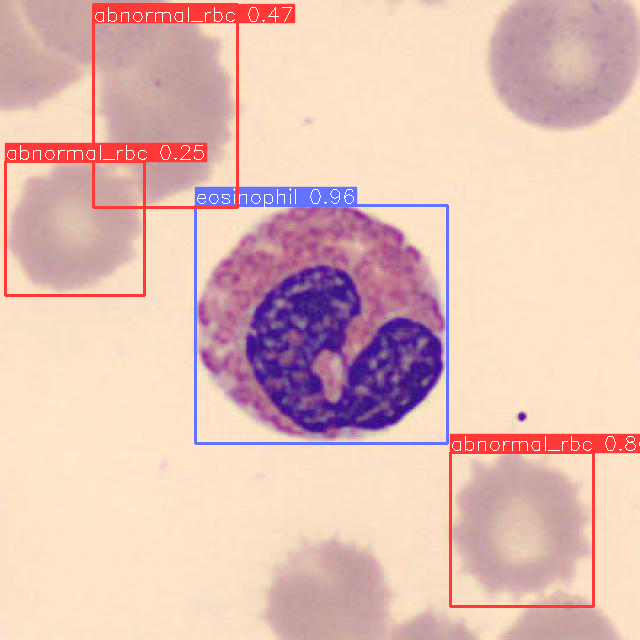

In [20]:
import os
model = YOLO('/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/runs/detect/train2/weights/best.pt')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# observe results
image_pth = "/content/AutoCBC/Milestone2_DiseaseDetect/YOLOv8/Disease-Detection-3/test/images"
image = os.listdir(image_pth)[0]
#image = "/content/AutoCBC/datasets/Disease-Detection-2/test/images/BA_100102_jpg.rf.6f8454a71b80f91564ba4494e041d87a.jpg"
#image = "datasets/data/Testing/images/BloodImage_00391.jpg"
image_pth_full = image_pth + "/" + image
results = model.predict(image_pth_full)

print(results[0].boxes)
render = render_result(model=model, image=image_pth_full, result=results[0])
render.show()



We will count the number of objects in each class and find the ratio of cells in each image

In [ ]:
results = model.predict(image, stream=True)
blood_count = {"RBC":0, "WBC":0, "Platelets":0}

for r in results:
    for c in r.boxes.cls:
      if model.names[int(c)] in blood_count.keys():
         blood_count[model.names[int(c)]] += 1

print(blood_count)

results = [blood_count['RBC']/sum(blood_count.values()), blood_count['WBC']/sum(blood_count.values()), blood_count['Platelets']/sum(blood_count.values())]

print(results)

image 1/1 /content/AutoCBC/datasets/data/Testing/images/BloodImage_00391.jpg: 480x640 19 RBCs, 1 WBC, 1 Platelets, 14.2ms
Speed: 3.1ms pre-process, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


{'RBC': 19, 'WBC': 1, 'Platelets': 1}
[0.9047619047619048, 0.047619047619047616, 0.047619047619047616]
